In [1]:
import numpy as np
import requests
import os
from numpy.linalg import eigh
import matplotlib.pyplot as plt
import mdtraj as md
import nglview as nv
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib as mpl

# Working with the Kirchoff matrix of the Gaussian Network Model

## Downloading any PDB file

Let's first of all store the PDB id we want to download and the path where the file needs to be located:

In [2]:
pdb_id = '1HIV'
download_path = "./"

And now let's define an auxiliary function to download pdb files to be stored locally in our machine.

In [3]:
def fetch_pdb(pdb_id, download_path="./"):
        url = 'http://files.rcsb.org/download/{}.pdb'.format(pdb_id)
        try:
            res = requests.get(url, allow_redirects=True)
        except:
            print("Could not fetch pdb from {}".format(url))
            return 
        
        file_path = os.path.join(download_path, pdb_id + ".pdb")
        with open(file_path, "wb") as f:
            f.write(res.content)
        print(f"The {pdb_id} file was downloaded succesfully!")

Time to try it!

In [4]:
fetch_pdb(pdb_id, download_path=download_path)

The 1HIV file was downloaded succesfully!


## Parsing the positions of the CA atoms

We are going take an approach not very short and efficiente to obtain the coordinates of the CA atoms. But let's do it this way just once:

In [5]:
file_path = os.path.join(download_path, pdb_id + ".pdb")

CA_coordinates = []

with open(file_path) as fff:
    for line in fff.readlines():
        if line.startswith('ATOM  ') and line.split()[2]=='CA' :
          
            x, y, z = line.split()[6:9]
            CA_coordinates.append([float(x), float(y), float(z)])

Ok, `CA_coordinates` is a list of lists... let's convert it to a numpy array:

In [6]:
CA_coordinates = np.array(CA_coordinates)

In [7]:
np.array([1,1])

array([1, 1])

In [8]:
#Alpha carbon number
len(CA_coordinates)

196

## Defining the Kirchhoff matrix

In [9]:
def kirchhoff_matrix(CA, threshold):
    num_CAs = CA.shape[0]
    matrix = np.zeros((num_CAs, num_CAs), dtype=int)
    for ii in range(num_CAs):
        for jj in range(ii):
            rij=CA[ii]-CA[jj]
            distance=np.sqrt(np.dot(rij,rij))
            if distance<threshold:
                matrix[ii,jj] = -1
                matrix[jj,ii] = -1
                matrix[ii,ii] += 1
                matrix[jj,jj] += 1
    return matrix

In [10]:
K_matrix = kirchhoff_matrix(CA_coordinates, 9.0)
K_matrix

array([[ 5, -1, -1, ..., -1, -1, -1],
       [-1,  7, -1, ..., -1, -1, -1],
       [-1, -1, 10, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., 16, -1, -1],
       [-1, -1, -1, ..., -1, 12, -1],
       [-1, -1, -1, ..., -1, -1, 10]])

## Diagonalizing from its eigenvalues

In [11]:
evals, evects = eigh(K_matrix)

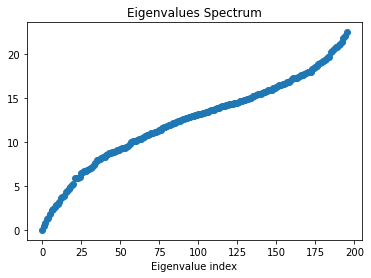

In [12]:
num_modes = evals.shape[0]

plt.scatter(range(num_modes), evals)
plt.title('Eigenvalues Spectrum')
plt.xlabel('Eigenvalue index')
plt.show()

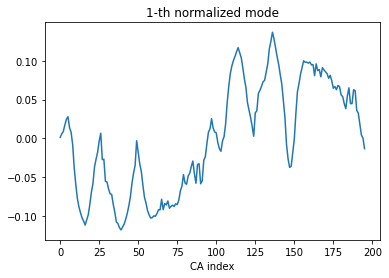

In [13]:
mode_index = 1
plt.plot(range(num_modes), evects[:,mode_index])
plt.title(f'{mode_index}-th normalized mode')
plt.xlabel('CA index')
plt.show()

## Obtaining $\Gamma^{-1}$ from the N-1 non-zero eigenvalues


In [14]:
#Removing 0 eigenvalue and corresponding eigenvector
evals_new=np.delete(evals,0)
evects_new=np.delete(evects,0,1)

In [15]:
#Defining the diagonalized matrix of eigenvalues
D=np.diag(evals_new)

In [16]:
#Defining invertible Kirchhoff matrix
K_matrix_inv=np.matmul(evects_new, np.matmul(np.linalg.inv(D),np.transpose(evects_new)))

In [17]:
#Defining the B factors
kb=1.38064852e-23 #Boltzmann constant
T=100 #Experimental temperature
f=6e-22 #Arbitrary force constant
B_Theory=[8*np.pi**2*kb*T/f*K_matrix_inv[ii][ii] for ii in range(len(K_matrix_inv))]

In [18]:
#Reading B factors from PDB
B_exp=[]
with open(file_path) as fff:
    for line in fff.readlines():
        if line.startswith('ATOM  ') and line.split()[2]=='CA' :
            
            Bi = line.split()[10]
            B_exp.append(float(Bi))

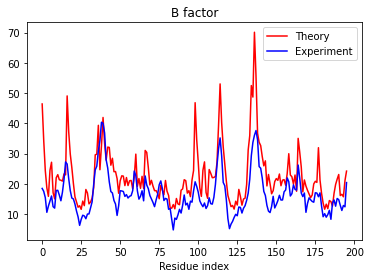

In [19]:
plt.plot(range(num_modes), B_Theory,c='red',label = 'Theory')
plt.plot(range(num_modes), B_exp,c='blue',label='Experiment')
plt.title('B factor')
plt.xlabel('Residue index')
plt.legend()
plt.show()

## Calculating correlation matrix from Kirchhoff Matrix

In [20]:
Corr_Matrix=3*kb*T/f*K_matrix_inv

In [21]:
Corr_Matrix.max()

2.664360078369951

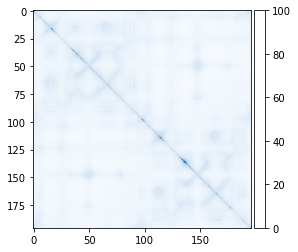

In [22]:
ax = plt.subplot()
im = ax.imshow(Corr_Matrix,cmap='Blues')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.xlim([0,100])
plt.ylim([0,100])
plt.show()

## Cartoon representation of B factors

In [23]:
traj = md.load(file_path)

In [24]:
atoms_in_protein = traj.topology.select('chainid 0 1')

In [25]:
traj_protein = traj.atom_slice(atoms_in_protein)

In [26]:
#Red color palette
pal = sns.color_palette('Reds', 7)
reds=pal.as_hex()

In [27]:
interval=np.linspace(11,71,8)#Dividing B factors value in 8 intervals
scheme=[]
for ii in range(1,100):
    for jj in range(7):
        if interval[jj] <=B_Theory[ii] < interval[jj+1]:
            scheme.append(['{}'.format(reds[jj]),'{}'.format(ii)])#Adding color according to B factor value


In [28]:
#Creating color scheme
colors=nv.color._ColorScheme(scheme,label=True)

In [31]:
view=nv.show_mdtraj(traj_protein)
view.clear_representations()
view.add_cartoon(color=colors)
view

NGLWidget()